In [1]:
%matplotlib inline
%load_ext lab_black

import os
import tarfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import autocorrelation_plot, lag_plot
import statsmodels.api as sm

resources = "resources/"
data_path = os.path.join(resources, "full_time_series.csv.gz")

# Data overview

In this notebook, we get acquainted with the features present in the dataset, and especially with `GPP`.
For this, we use the site `CZ-RAJ`, which is the time series which we set aside at the previous step.

## Data loading

In [2]:
# Loading the selected data
df = pd.read_csv(data_path)
df["TIMESTAMP"] = pd.to_datetime(df["TIMESTAMP"])
# We add time derived features
df["month"] = df["TIMESTAMP"].dt.month
df["year"] = df["TIMESTAMP"].dt.year
df["day_of_year"] = df["TIMESTAMP"].dt.dayofyear
# We set the sitename and date as indexes
df.set_index(["TIMESTAMP"], drop=True, inplace=True)
df.index.names = ["date"]

print(f"Number of samples: {len(df)}")

Number of samples: 3288


## Feature list

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3288 entries, 2012-01-01 to 2020-12-31
Data columns (total 46 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   P_F               3288 non-null   float64
 1   P_F_QC            0 non-null      float64
 2   TA_F_MDS          3288 non-null   float64
 3   TA_F_MDS_QC       3288 non-null   float64
 4   TMIN_F_MDS        3288 non-null   float64
 5   TMAX_F_MDS        3288 non-null   float64
 6   SW_IN_F_MDS       3288 non-null   float64
 7   SW_IN_F_MDS_QC    3288 non-null   float64
 8   LW_IN_F_MDS       3288 non-null   float64
 9   LW_IN_F_MDS_QC    3288 non-null   float64
 10  VPD_F_MDS         3288 non-null   float64
 11  VPD_F_MDS_QC      3288 non-null   float64
 12  WS_F              3240 non-null   float64
 13  WS_F_QC           3288 non-null   float64
 14  PA_F              3288 non-null   float64
 15  PA_F_QC           0 non-null      float64
 16  CO2_F_MDS         3288 n

All the features, except the site name and the timestamp are numerical.

Here is an explanation of the features:

| Variable           | Description                                                               |
|--------------------|---------------------------------------------------------------------------|
| TIMESTAMP          | Timestamp (day)                                                           |
| GPP_NT_VUT_REF     | GPP Night time                                                            |
| GPP_DT_VUT_REF     | GPP Day time                                                              |
| P_F*               | Precipitation (mm) filled                                                 |
| TMIN_F_MDS*        | TA Min                                                                    |
| TMAX_F_MDS*        | TA Max                                                                    |
| TA_F_MDS*          | Air temp                                                                  |
| SW_IN_F_MDS*       | Incoming shortwave radiation                                              |
| LW_IN_F_MDS*       | Incoming (down-welling) longwave radiation                                |
| VPD_F_MDS*         | Vapor Pressure Deficit                                                    |
| WS_F*              | Wind speed                                                                |
| PA_F*              | Atmospheric pressure                                                      |
| CO2_F_MDS*         | Carbon Dioxide (CO2) mole fraction                                        |
| NETRAD*            | Net radiation                                                             |
| USTAR*             | Water friction velocity (u*-threshold method)                             |
| SW_OUT             | Shortwave radiation, outgoing                                             |
| LE_F_MDS*          | Latent heat flux                                                          |
| LE_CORR*           | Latent heat flux (energy enforced closure)                                |
| LE_CORR_JOINTUNC   | Joint uncertainty correction for LE                                       |
| H_F_MDS*           | Sensible heat flux                                                        |
| H_CORR*            | Sensible heat flux (energy enforced closure)                              |
| H_CORR_JOINTUNC    | Joint uncertainty correction for H                                        |
| NEE_NT_VUT_REF*    | Net Ecosystem Exchange                                                    |
| RECO_NT_VUT_REF    | Ecosystem respiration                                                     |
| LAI                | Leaf area index                                                           |
| FPAR               | Fraction of absorbed photosynthetically active radiation (fAPAR)          |
| TA_DAY_F_MDS*      | Temp air mean day time                                                    |	
| VPD_DAY_F_MDS*     | Vapor Pressure Deficit day time                                           |

**Note:** Feature names followed by an asterisk (\*) denote features having a corresponding quality flag feature (more detail on this later).

Let us plot some features:

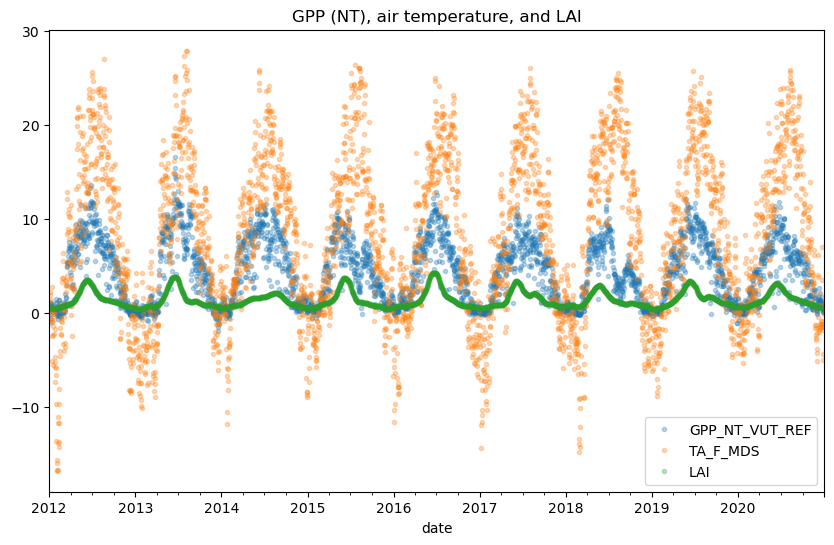

In [4]:
df[["GPP_NT_VUT_REF", "TA_F_MDS", "LAI"]].plot(style=".", alpha=0.3, figsize=(10, 6))
plt.legend()
plt.title(f"GPP (NT), air temperature, and Leaf area index")
plt.show()

We can already see that `GPP` is correlated with the air temperature and LAI and follows seasonal variations.
Let us look more into the patterns in `GPP`.

## Target variable `GPP`

Firstly, there are two features which estimate GPP: `GPP_NT_VUT_REF` and `GPP_DT_VUT_REF`, 
which correspond to two independent methods for accessing GPP (`NT` stands for nighttime, and `DT` stands for daytime).
Let us plot both features to appreciate visually how closely they correlate:

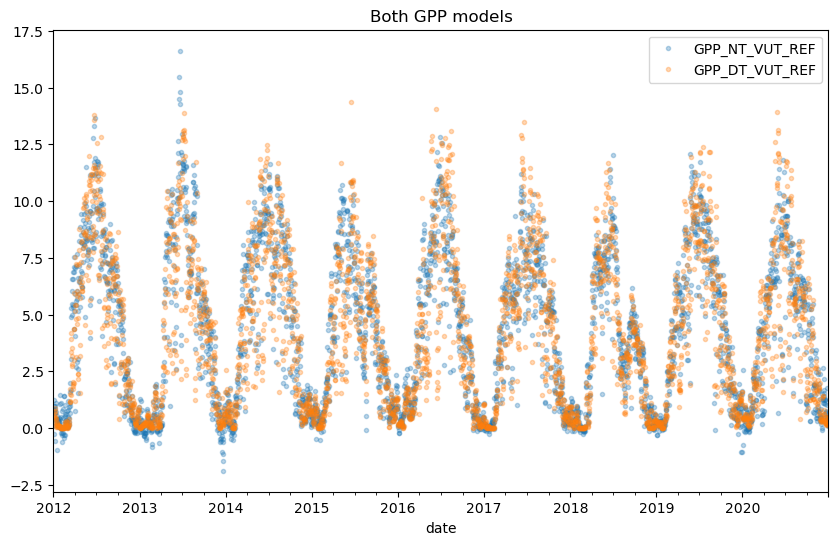

In [5]:
df[["GPP_NT_VUT_REF", "GPP_DT_VUT_REF"]].plot(style=".", alpha=0.3, figsize=(10, 6))
plt.legend()
plt.title(f"GPP NT and DT models")
plt.show()

The [dataset documentation](https://fluxnet.org/data/fluxnet2015-dataset/variables-quick-start-guide/) recommends to use both for more robust measures of GPP, and to use the difference for assessing the uncertainty.
So we do: we define `GPP` as the mean of `GPP_NT_VUT_REF` and `GPP_DT_VUT_REF`, while `GPP_diff` is their difference:

In [6]:
df["GPP"] = df[["GPP_NT_VUT_REF", "GPP_DT_VUT_REF"]].mean(axis=1, skipna=False)
df["GPP_diff"] = df["GPP_NT_VUT_REF"] - df["GPP_DT_VUT_REF"]

Let us plot the histogram of `GPP` and `GPP_diff`:

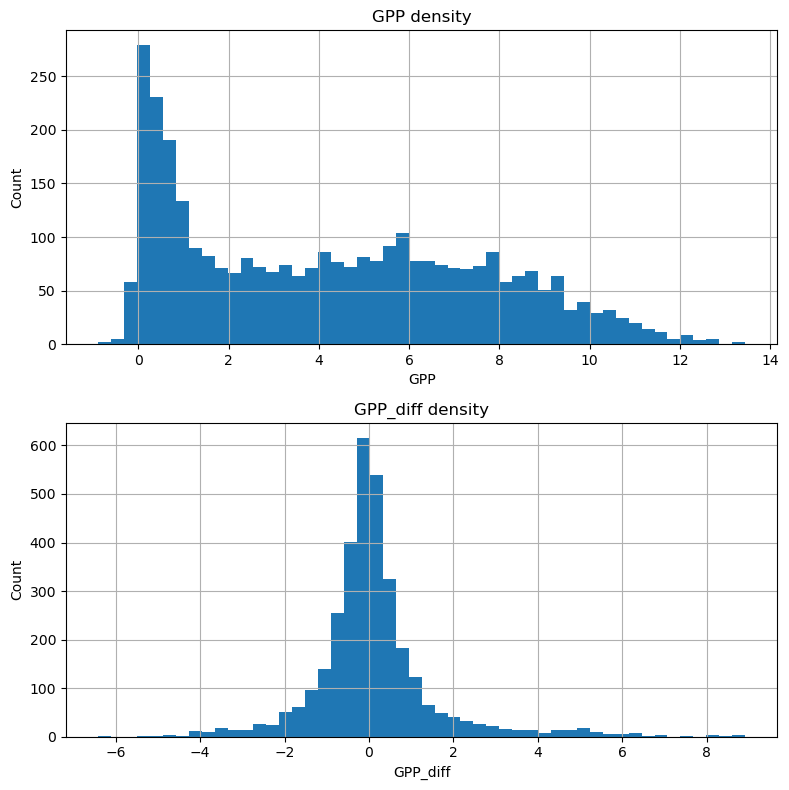

In [7]:
fig, [ax0, ax1] = plt.subplots(ncols=1, nrows=2, figsize=(8, 8))
df["GPP"].hist(bins=50, ax=ax0)
ax0.set_title("GPP density")
ax0.set_xlabel("GPP")
ax0.set_ylabel("Count")
df["GPP_diff"].hist(bins=50, ax=ax1)
ax1.set_title("GPP_diff density")
ax1.set_xlabel("GPP_diff")
ax1.set_ylabel("Count")
plt.tight_layout()
plt.show()

We can see that the GPP error is centered on zero and has a fairly normal profile indicating that both models agree most of the time.
This comforts us into our strategy of taking the mean of both models should lead to a fairly robust estimator of `GPP`.

### Trend, cycles and autocorrelation

Let us look at the evolution of GPP with time.

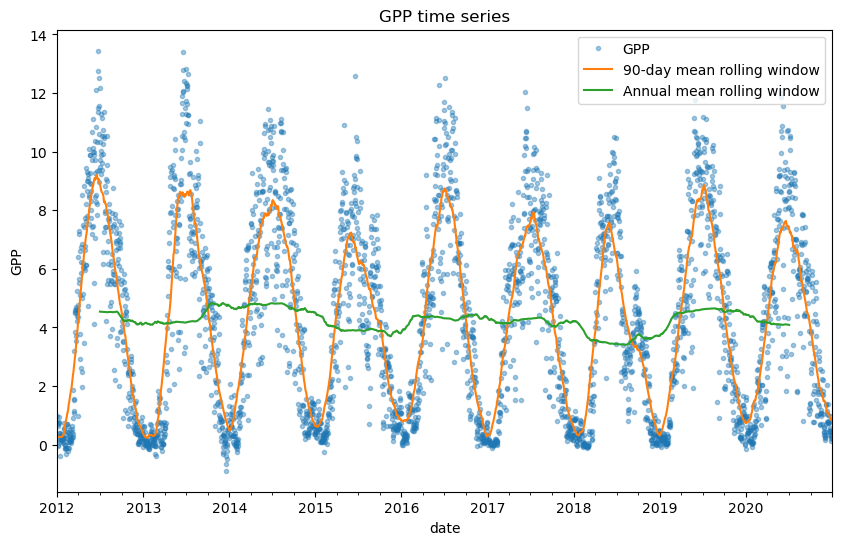

In [8]:
df["GPP"].plot(style=".", alpha=0.4, figsize=(10, 6))
df["GPP"].rolling("90d", center=True).mean().plot(label="90-day mean rolling window")
df["GPP"].rolling("365d", center=True, min_periods=365).mean().plot(
    label="Annual mean rolling window"
)
plt.title(f"GPP time series")
plt.ylabel("GPP")
plt.legend()
plt.show()

Notes:
- We can clearly see a yearly seasonality.
- There is no obvious trend.
- There might be a decrease in variance with time.

Looking at the diagrams below:

- The yearly average shows maybe a slight downward trend.
- The monthly distribution shows a clear yearly seasonality, with GPP being close to 0 during winter time, and maximum during summer time.
The variance follows the same pattern.
- The seasonal shift is not very pronounced.
We notice a potential upward trend in April and December and downward trend in June, but these are not significant.

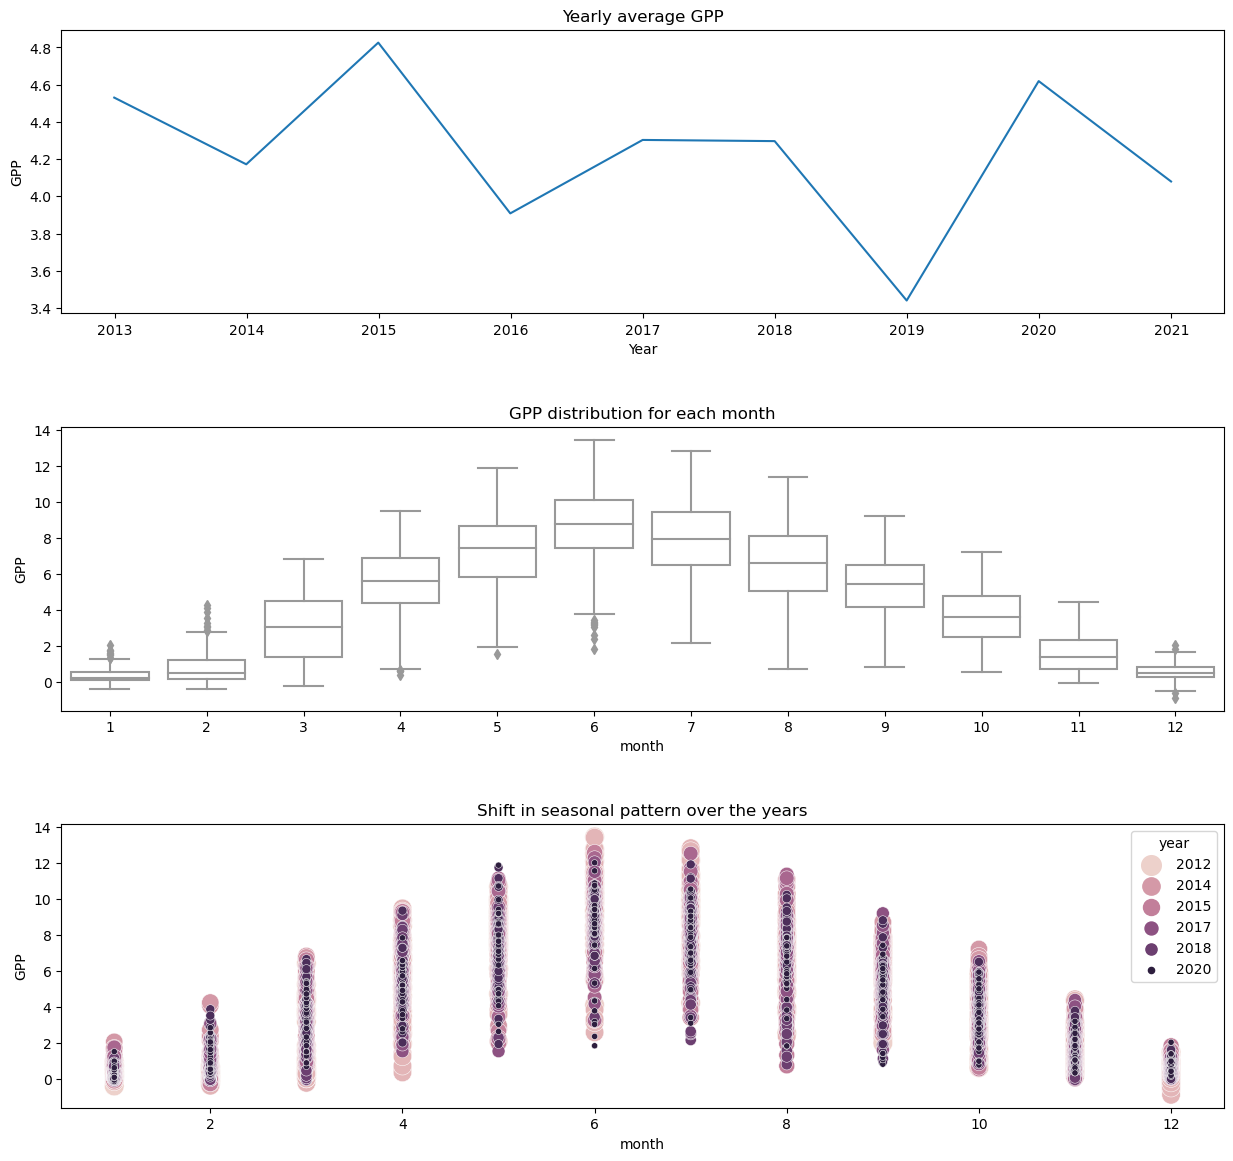

In [9]:
fig, axes = plt.subplots(3, 1, figsize=(15, 14), gridspec_kw={"hspace": 0.4})

# 1st plot: line plot of average temperature per decade (A: annual)
axes[0].plot(df["GPP"].resample("A").mean())
axes[0].set_title("Yearly average GPP")
axes[0].set_xlabel("Year")
axes[0].set_ylabel("GPP")

# 2nd plot: box plot of monthly GPP for every month
sns.boxplot(data=df, x="month", y="GPP", color="white", ax=axes[1])
axes[1].set_title("GPP distribution for each month")

# 3rd plot: scatter plot of monthly GPP against month
sns.scatterplot(data=df, x="month", y="GPP", hue="year", size="year", sizes=(200, 20))
axes[2].set_title("Shift in seasonal pattern over the years")

plt.show()

The diagram below shows that the day-to-day changes in GPP follow a fairly normal, unbiased distribution.
This means that there is a good autocorrelation with lag 1 and confirms the lack of trend.
There is a seasonality effect (higher variability in summer), but overall we do not observe a major change in pattern over the years.

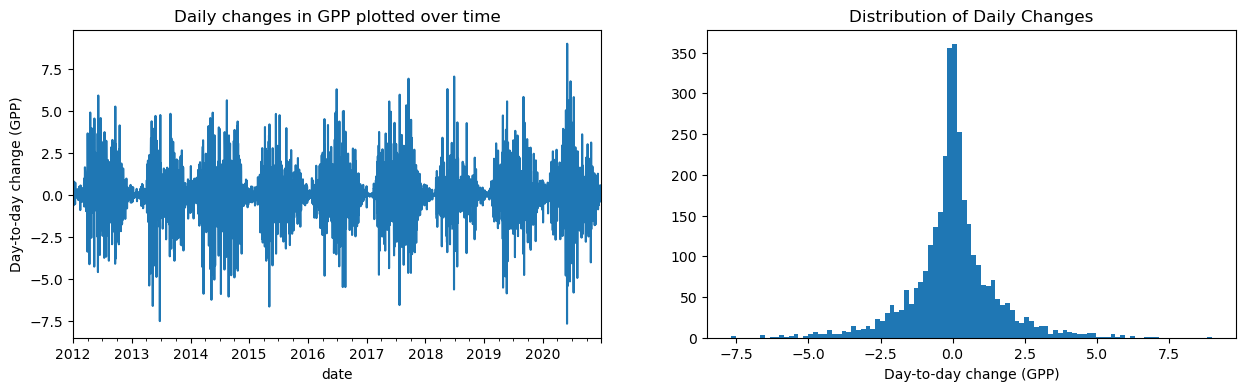

In [10]:
# Compute first difference of GPP for site AT-Neu
diff = df["GPP"].diff(1)

# the subplot on the left
plt.subplot(121)
diff.plot(figsize=(15, 4))
plt.title("Daily changes in GPP plotted over time")
plt.ylabel("Day-to-day change (GPP)")

# the subplot on the right
plt.subplot(122)
diff.hist(figsize=(15, 4), bins=100, grid=False)
plt.title("Distribution of Daily Changes")
plt.xlabel("Day-to-day change (GPP)")

plt.show()

We now plot the autocorrelation curves:

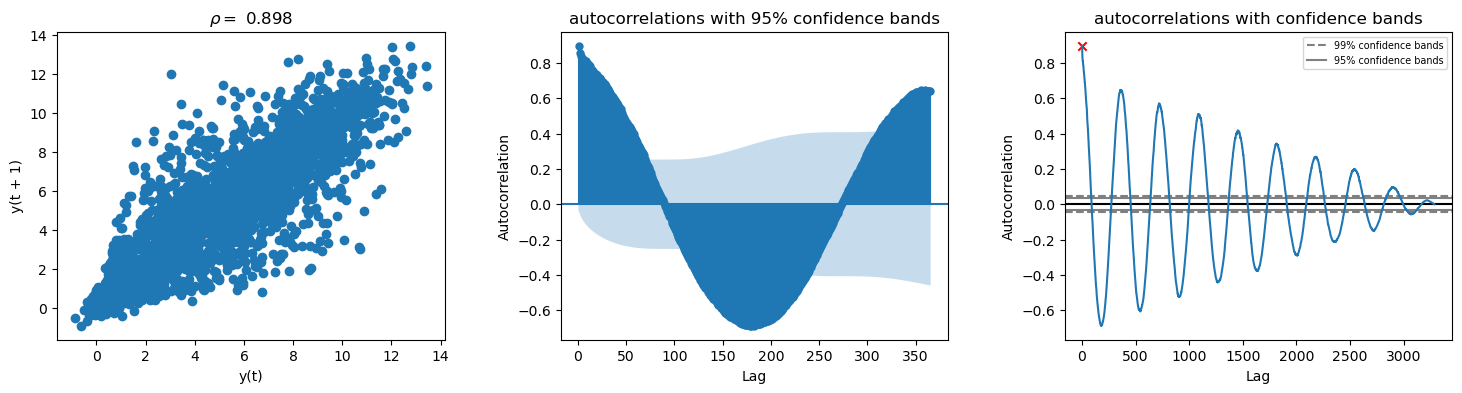

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 4), gridspec_kw={"wspace": 0.3})

d = df["GPP"]

# 1st plot: scatter plot of GPP against its 1st lag
lag_plot(d, ax=axes[0], lag=1)
axes[0].set_title(r"$\rho = $ {:.3f}".format(d.autocorr(1)))

# 2nd plot: Autocorrelations up to 365 day lags
sm.graphics.tsa.plot_acf(df["GPP"], lags=365, alpha=0.05, zero=False, ax=axes[1])
axes[1].set_xlabel("Lag")
axes[1].set_ylabel("Autocorrelation")
axes[1].set_title("autocorrelations with 95% confidence bands")

# 3rd plot: autocorrelations over multiple years
autocorrelation_plot(d, ax=axes[2])
axes[2].set_title("autocorrelations with confidence bands")
axes[2].legend(["99% confidence bands", "95% confidence bands"], fontsize="x-small")
axes[2].grid()

# Red cross on the 1st autocorrelation value
axes[2].scatter(1, d.autocorr(1), marker="x", c="red")

plt.show()

As expected, the autocorrelation with lag 1 is very high (0.90) and decreases to reach a new weaker peak 6 month later (in opposition of phase) and another peak one year later.

## Summary

We have looked at one site (`CZ-RAJ`) to get to know the features present in the data and had a close look at the temporal characteristics of `GPP`.
From now on, we depart from the temporal domain to work on timeless data, but we will come back to this site at the end of the study to test our models on a whole time series.